# Trabajo práctico integrador

**Nombre**:

## Primera Parte (Clase 1 y 2)

In [3]:
import numpy as np
import matplotlib.pyplot as plt

### Primer ejercicio

Dada una matriz en formato *numpy array*, donde cada fila de la matriz representa un vector matemático, se requiere computar las normas $l_0$, $l_1$, $l_2$, $l_{\infty}$, según la siguientes definiciones:

\begin{equation}
    ||\mathbf{x}||^{p} = \bigg(\sum_{j=1}^{n}{|x_i|^p}\bigg)^{\frac{1}{p}}
\end{equation}

con los casos especiales para $p=0$ y $p=\infty$ siendo:

\begin{equation}
    \begin{array}{rcl}
        ||\mathbf{x}||_0 & = & \bigg(\sum_{j=1 \wedge x_j != 0}{|x_i|}\bigg)\\
        ||\mathbf{x}||_{\infty} & = & \max_{i}{|x_i|}\\
    \end{array}
\end{equation}

In [2]:
import numpy as np

# Creamos una matriz de ejemplo
matriz = np.array([[1, 2, 3], [4, 5, 6], [0, 0, 0]])

# Calculamos las normas
n_l0 = np.count_nonzero(matriz, axis=1)
n_l1 = np.linalg.norm(matriz, ord=1, axis=1)
n_l2 = np.linalg.norm(matriz, ord=2, axis=1)
n_linfinito = np.max(np.abs(matriz), axis=1)

# Imprimimos los resultados
print("Norma l0: ", n_l0)
print("Norma l1: ", n_l1)
print("Norma l2: ", n_l2)
print("Norma linfinito: ", n_linfinito)

Norma l0:  [3 3 0]
Norma l1:  [ 6. 15.  0.]
Norma l2:  [3.74165739 8.77496439 0.        ]
Norma linfinito:  [3 6 0]


### Segundo Ejercicio

En clasificación contamos con dos arreglos, la “verdad” y la “predicción”. Cada elemento de los arreglos pueden tomar dos valores, “True” (representado por 1) y “False” (representado por 0). Entonces podemos definir 4 variables:

* True Positive (TP): El valor verdadero es 1 y el valor predicho es 1
* True Negative (TN): El valor verdadero es 0 y el valor predicho es 0
* False Positive (FP): El valor verdadero es 0 y el valor predicho es 1
* False Negative (FN): El valor verdadero es 1 y el valor predicho es 0

A partir de esto definimos:

* Precision = TP / (TP + FP)
* Recall = TP / (TP + FN)
* Accuracy = (TP + TN) / (TP + TN + FP + FN)
 
Calcular las 3 métricas con Numpy y operaciones vectorizadas.

In [4]:
truth = np.array([1,1,0,1,1,1,0,0,0,1])
prediction = np.array([1,1,1,1,0,0,1,1,0,0])

TP = np.sum((truth==1)&(prediction==1))
TN = np.sum((truth==0)&(prediction==0))
FP = np.sum((truth==0)&(prediction==1))
FN = np.sum((truth==1)&(prediction==0))
Precision = TP/(TP+FP)
Recall = TP / ( TP + FN )
Accuracy = ( TP + TN ) / ( TP + TN + FP + FN )
print('TP: {0} \
      \nTN: {1} \
      \nFP: {2} \
      \nFN: {3} \
      \nPrecision: {4:.3f} \
      \nRecall: {5:.2f} \
      \nAccuracy: {6:.3f}'.format(TP, TN, FP, FN, Precision, Recall, Accuracy))

TP: 3       
TN: 1       
FP: 3       
FN: 3       
Precision: 0.500       
Recall: 0.50       
Accuracy: 0.400


### Tercer y Cuarto Ejercicio

Para este ejercicio vamos a considerar los siguientes datasets:

* [HAR](https://archive.ics.uci.edu/ml/datasets/Human+Activity+Recognition+Using+Smartphones) (Ejercicio 3)
* [MNIST](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_digits.html) (Ejercicio 4)

1. Aplicar PCA (validar que se cumplan las condiciones), ¿Cuántos componentes necesitamos para explicar el 80% de la varianza?
2. Gráficar la variación acumulada para cada caso.
3. Utilizando [KMeans](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html). Agrupar el dataset transformado (ejercicio de PCA) y agrupar en clusters de $k=6$ (ej 3) y $k=10$ (ej 4). Luego en ambos casos probar con $k=2$.
4. Graficar los resultados con los distintos k's usando las primeras dos componentes principales como ejes x,y.
5. Explique. ¿Cuál fue la ganancia de usar PCA en conjunto con k-means?

In [5]:
import os

from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler


RANDOM_STATE = 17

----- HAR -----

In [6]:
#HAR
PATH_DATASET = "./UCI HAR Dataset/train"
X_train = np.loadtxt(os.path.join(PATH_DATASET, "X_train.txt"))
y_train = np.loadtxt(os.path.join(PATH_DATASET, "y_train.txt")).astype(int)

1.

In [7]:

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_train)
pca = PCA(n_components=0.8, random_state=RANDOM_STATE).fit(X_scaled)
X_pca = pca.transform(X_scaled)
 
print(X_pca.shape[1], "componentes necesarios para explicar el 80%"+" de la varianza")

26 componentes necesarios para explicar el 80% de la varianza


2.

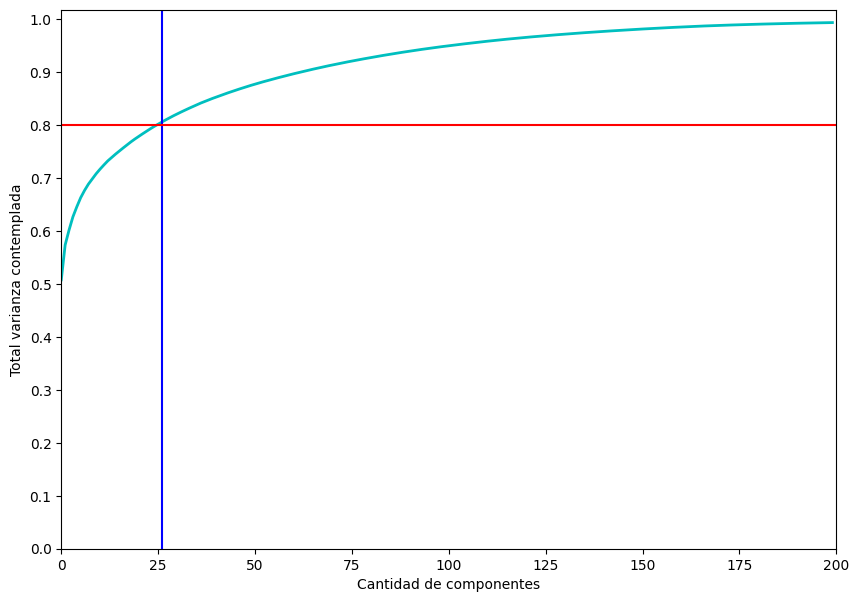

In [8]:
pca_2 = PCA(n_components=200, random_state=RANDOM_STATE).fit(X_scaled)

plt.figure(figsize=(10,7))
plt.plot(np.cumsum(pca_2.explained_variance_ratio_), color='c', lw=2)
plt.xlabel('Cantidad de componentes')
plt.ylabel('Total varianza contemplada')
plt.xlim(0, 200)
plt.yticks(np.arange(0, 1.1, 0.1))
plt.axvline(26, c='b')
plt.axhline(0.8, c='r')
plt.show();

3. - 4.

/tmp/ipykernel_27546/4011140890.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  plt.scatter(X_pca[:, 0], X_pca[:, 1], s=25, c=cluster_labels, cmap=plt.cm.get_cmap('nipy_spectral', 6), alpha=0.7)
/tmp/ipykernel_27546/4011140890.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  plt.scatter(centroids_1[:, 0], centroids_1[:, 1],c='red',marker='.', s=25, cmap=plt.cm.get_cmap('nipy_spectral', 6), alpha=0.7)
/tmp/ipykernel_27546/4011140890.py:8: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(centroids_1[:, 0], centroids_1[:, 1],c='red',marker='.', s=25, cmap=plt.cm.get_cmap('nipy_spectral', 

Text(0.5, 1.0, 'HAR - PCA')

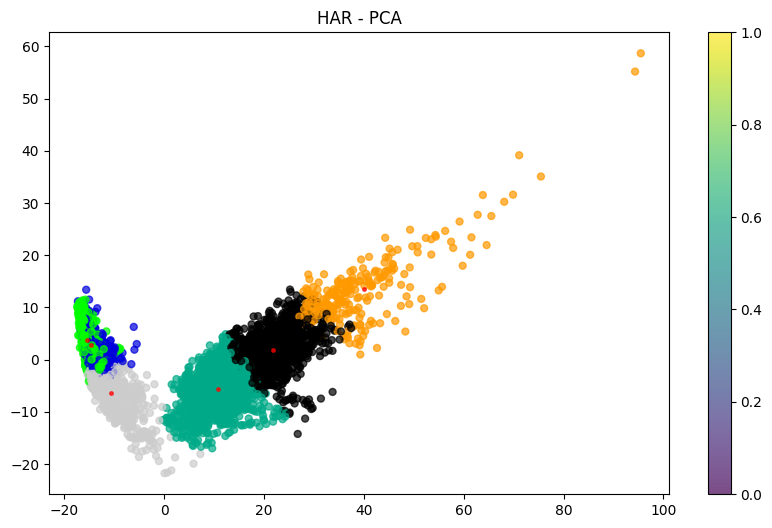

In [26]:
kmeans_1 = KMeans(n_clusters=6, n_init=100, random_state=RANDOM_STATE)
kmeans_1.fit(X_pca)
cluster_labels = kmeans_1.labels_
centroids_1 = kmeans_1.cluster_centers_

plt.figure(figsize=(10,6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], s=25, c=cluster_labels, cmap=plt.cm.get_cmap('nipy_spectral', 6), alpha=0.7)
plt.scatter(centroids_1[:, 0], centroids_1[:, 1],c='red',marker='.', s=25, cmap=plt.cm.get_cmap('nipy_spectral', 6), alpha=0.7)
plt.colorbar()
plt.title('HAR - PCA')

In [27]:
tab = pd.crosstab(y_train, cluster_labels, margins=True)
tab.index = ['Caminar', 'Subir escaleras', 'Bajar escaleras', 'Estar parado', 'Estar sentado', 'Recostarse', 'Todos']
tab.columns = ['cluster ' + str(i + 0) for i in range(6)] + ['Todos']
tab

,cluster 0,cluster 1,cluster 2,cluster 3,cluster 4,cluster 5,Todos
Caminar,503,0,655,0,68,0,1226
Subir escaleras,207,0,861,0,3,2,1073
Bajar escaleras,622,0,204,0,160,0,986
Estar parado,0,875,1,97,0,313,1286
Estar sentado,0,1003,0,0,0,371,1374
Recostarse,0,24,4,1112,0,267,1407
Todos,1332,1902,1725,1209,231,953,7352


In [28]:
kmeans_2 = KMeans(n_clusters=2, n_init=100, random_state=RANDOM_STATE)
kmeans_2.fit(X_pca)
cluster_labels_mov = kmeans_2.labels_
centroids_2 = kmeans_2.cluster_centers_

/tmp/ipykernel_27546/3241747811.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  plt.scatter(X_pca[:, 0], X_pca[:, 1], s=25, c=cluster_labels_mov, cmap=plt.cm.get_cmap('nipy_spectral', 2),edgecolor='none', alpha=0.7)
/tmp/ipykernel_27546/3241747811.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  plt.scatter(centroids_2[:, 0], centroids_2[:, 1],c='red',marker='.', s=25, cmap=plt.cm.get_cmap('nipy_spectral', 2), alpha=0.7)
/tmp/ipykernel_27546/3241747811.py:4: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(centroids_2[:, 0], centroids_2[:, 1],c='red',marker='.', s=25, cmap=plt.cm.get_c

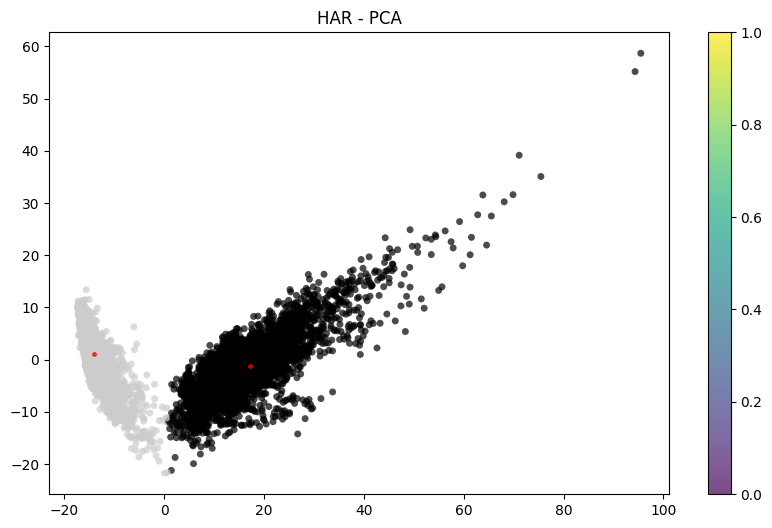

In [29]:
# Graficamos los primeros dos componentes - clusters id
plt.figure(figsize=(10,6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], s=25, c=cluster_labels_mov, cmap=plt.cm.get_cmap('nipy_spectral', 2),edgecolor='none', alpha=0.7)
plt.scatter(centroids_2[:, 0], centroids_2[:, 1],c='red',marker='.', s=25, cmap=plt.cm.get_cmap('nipy_spectral', 2), alpha=0.7)
plt.colorbar()
plt.title('HAR - PCA');

In [100]:
tab = pd.crosstab(y_train, cluster_labels_mov, margins=True)
tab.index = ['Caminar', 'Subir escaleras', 'Bajar escaleras', 'Estar parado', 'Estar sentado', 'Recostarse', 'Todos']
tab.columns = ['cluster ' + str(i + 0) for i in range(2)] + ['Todos']
tab

,cluster 0,cluster 1,Todos
Caminar,1226,0,1226
Subir escaleras,1065,8,1073
Bajar escaleras,986,0,986
Estar parado,1,1285,1286
Estar sentado,0,1374,1374
Recostarse,11,1396,1407
Todos,3289,4063,7352


5.

En el análisis exploratorio del conjunto de datos para representar el 80% de varianza es necesario analizar solo 26 componentes. K-means clustering intenta agrupar tipos similares de elementos en forma de grupos. Sin embargo, es importante tener en cuenta que la elección y la interpretación de una medida de ganancia específica dependerá del contexto y los objetivos del análisis de datos, y podría variar en diferentes aplicaciones y escenarios.

----- MNIST -----

(1797, 64)


<Figure size 640x480 with 0 Axes>

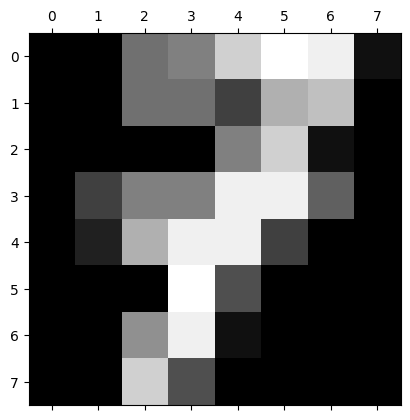

In [101]:
from sklearn.datasets import load_digits
digits = load_digits()
print(digits.data.shape)

import matplotlib.pyplot as plt
plt.gray()
plt.matshow(digits.images[7])

plt.show()

X_train, y_train = load_digits(return_X_y=True)

1.

In [102]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_train)
pca = PCA(n_components=0.8, random_state=RANDOM_STATE).fit(X_scaled)
X_pca = pca.transform(X_scaled)

print(X_pca.shape[1], "componentes necesarios para explicar el 80%"+" de la varianza")

21 componentes necesarios para explicar el 80% de la varianza


2.

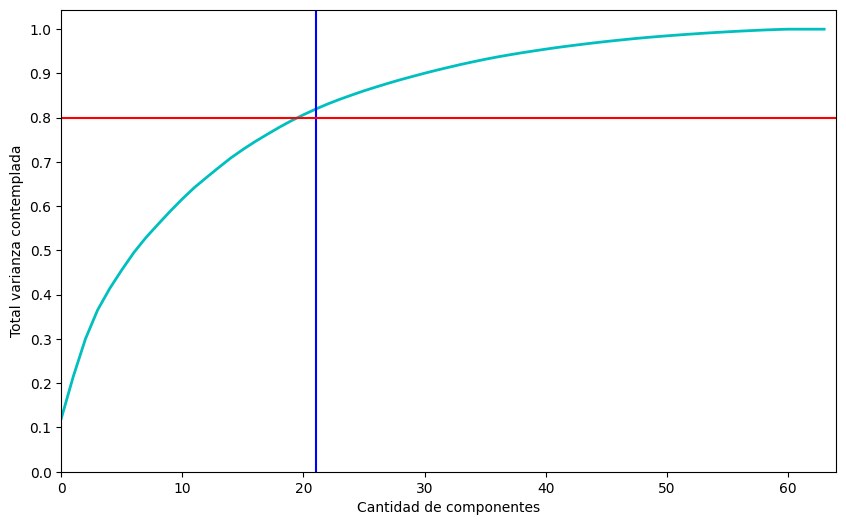

In [114]:
pca_2 = PCA(n_components=64, random_state=RANDOM_STATE).fit(X_scaled)

plt.figure(figsize=(10,6))
plt.plot(np.cumsum(pca_2.explained_variance_ratio_), color='c', lw=2)
plt.xlabel('Cantidad de componentes')
plt.ylabel('Total varianza contemplada')
plt.xlim(0, 64)
plt.yticks(np.arange(0, 1.1, 0.1))
plt.axvline(21, c='b')
plt.axhline(0.8, c='r')
plt.show();

3. - 4.

In [115]:
kmeans = KMeans(n_clusters=10, n_init=100, random_state=RANDOM_STATE)
kmeans.fit(X_pca)
cluster_labels = kmeans.labels_

/tmp/ipykernel_14847/2163562564.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  plt.scatter(X_pca[:, 0], X_pca[:, 1], s=25, c=cluster_labels, cmap=plt.cm.get_cmap('nipy_spectral', 10), edgecolor='none', alpha=0.7)


Text(0.5, 1.0, 'MNIST - PCA')

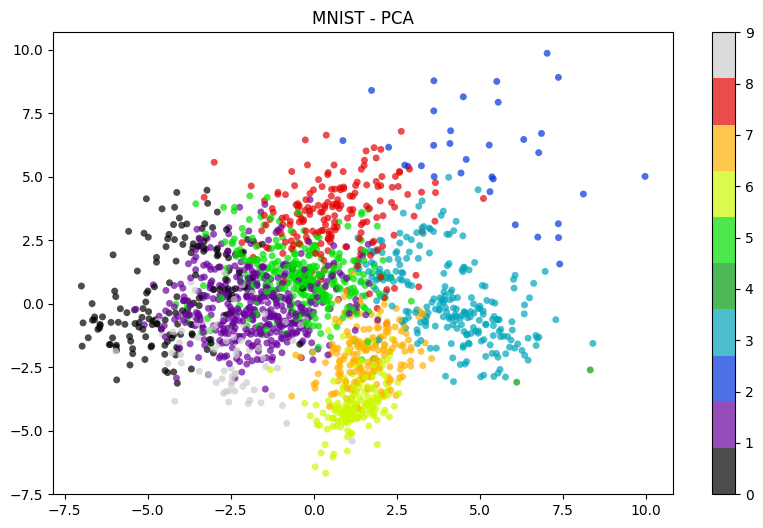

In [119]:
# Graficamos los primeros dos componentes - clusters id
plt.figure(figsize=(10,6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], s=25, c=cluster_labels, cmap=plt.cm.get_cmap('nipy_spectral', 10), edgecolor='none', alpha=0.7)
plt.rcParams['axes.grid'] = False
plt.colorbar()
plt.title('MNIST - PCA')


In [120]:
tab = pd.crosstab(y_train, cluster_labels, margins=True)
tab.columns = ['cluster ' + str(i + 0) for i in range(10)] + ['Todos']
tab

,cluster 0,cluster 1,cluster 2,cluster 3,cluster 4,cluster 5,cluster 6,cluster 7,cluster 8,cluster 9,Todos
row_0,,,,,,,,,,,
0,0,0,0,2,0,0,0,176,0,0,178
1,1,1,0,49,0,104,0,0,0,27,182
2,87,4,0,5,1,28,0,0,2,50,177
3,13,152,0,0,0,10,0,0,7,1,183
4,0,0,9,157,2,4,0,0,9,0,181
5,42,71,0,3,0,61,3,0,2,0,182
6,0,0,0,1,0,5,173,1,0,1,181
7,8,0,19,1,0,0,0,0,151,0,179
8,11,48,0,4,0,104,3,0,4,0,174


In [121]:
kmeans = KMeans(n_clusters=2, n_init=100, random_state=RANDOM_STATE)
kmeans.fit(X_pca)
cluster_labels = kmeans.labels_

/tmp/ipykernel_14847/342730473.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  plt.scatter(X_pca[:, 0], X_pca[:, 1], s=25, c=cluster_labels, cmap=plt.cm.get_cmap('nipy_spectral', 2), edgecolor='none', alpha=0.7)


Text(0.5, 1.0, 'MNIST - PCA')

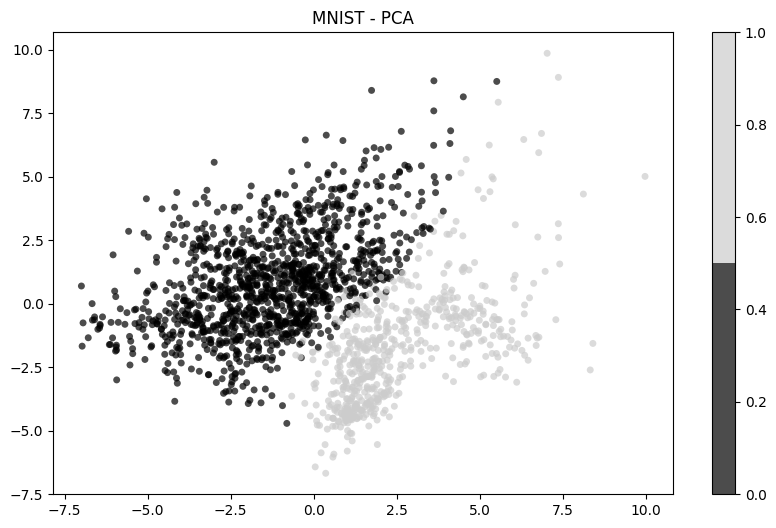

In [122]:
plt.figure(figsize=(10,6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], s=25, c=cluster_labels, cmap=plt.cm.get_cmap('nipy_spectral', 2), edgecolor='none', alpha=0.7)
plt.rcParams['axes.grid'] = False
plt.colorbar()
plt.title('MNIST - PCA')

In [123]:
tab = pd.crosstab(y_train, cluster_labels, margins=True)
tab.columns = ['cluster ' + str(i + 0) for i in range(2)] + ['Todos']
tab

,cluster 0,cluster 1,Todos
row_0,,,
0,0,178,178
1,174,8,182
2,176,1,177
3,180,3,183
4,5,176,181
5,169,13,182
6,0,181,181
7,166,13,179
8,167,7,174


5.

El gráfico muestra un grupo de puntos con la proyección de PCA. En la colección de elementos discretos relacionados de datos no hay una separación significativa.

## Segunda Parte (Clase 3 y 4)

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Entrenamiento de modelos de prueba
from sklearn.linear_model import LinearRegression

# Evaluación de modelos de prueba
from sklearn.metrics import mean_squared_error

# Crear datasets
from sklearn.datasets import make_regression

Vamos a crear un dataset sintetico utilizando las librerias de [Sklearn Datasets](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_regression.html), en particular nos interesa crear un problema de regresion
lineal al que podemos variarle sus parametros

In [19]:
# Creamos un dataset de prueba
X, y = make_regression(n_samples = 1000,
                       n_features = 1,
                       noise = 2,
                       n_informative = 1,
                       random_state = 42)

new_data = np.append(X,y.reshape(-1,1),axis=1)
new_data.shape

(1000, 2)

In [20]:
df = pd.DataFrame(new_data)

new_col = []
i = 0
for col in df.columns:
    if i ==  len(df.columns) - 1:
        new_col.append("target")
    else :
        new_col.append("feature_" + str(i+1))
        
    i += 1
    
df.columns = new_col

df.head()

,feature_1,target
0,-1.758739,-30.118736
1,1.031845,14.526197
2,-0.487606,-10.119305
3,0.186454,1.700188
4,0.725767,12.345314


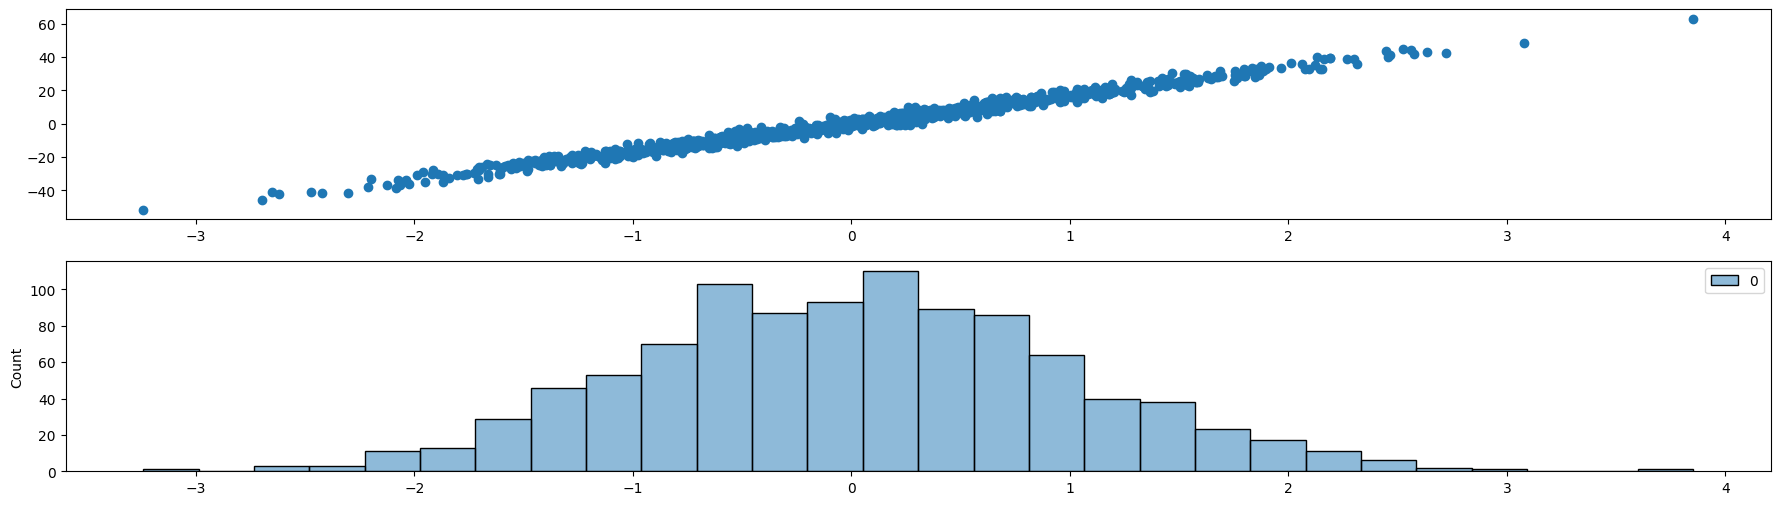

In [21]:
fig,axes = plt.subplots(2,figsize=(22,6))
axes[0].scatter(X,y)
sns.histplot(X, ax=axes[1]);

### Funciones auxiliares para generar datos anómalos

In [22]:
def generate_outliers(df: pd.DataFrame,
                     cols: list = None,
                     extreme_outlier: bool = False,
                     two_tailed: bool = False,
                     percentage: float = 0.02) -> pd.DataFrame:
  """Con esta función vamos a poder generar outliers en ciertas columnas de nuestro
  dataset. Si le damos True a _extreme_outlier_ va a generar outliers con mucho
  peso en la regresión (puede ser bilateral o unilateral segun _two_tailed_)
  """  
  seeds = np.random.randint(100, size = len(df))
  
  nsamples = np.math.floor(len(df) * percentage)
  idx_to_change = df.sample(n = nsamples).index

  cols = df.columns.tolist() if cols is None else cols

  result = df.copy(deep = True)
  
  for i,col_name in enumerate(cols):
    np.random.seed(seeds[i])

    iqr = result[col_name].quantile(0.75) - result[col_name].quantile(0.25)

    lb = result[col_name].quantile(0.25) - 1 * iqr
    ub = result[col_name].quantile(0.75) + 1 * iqr

    if two_tailed:
      outs = result[col_name].loc[(result[col_name] < lb) | (result[col_name] > ub)]
    else:
      outs = result[col_name].loc[(result[col_name] > ub)]
    
    out_size = len(outs)
    if out_size < nsamples:
      nsamples = out_size

    idx_to_change = outs.sample(nsamples, replace = False).index
    
    if extreme_outlier:
      outlier_sign = [1 if np.random.random() < 0.9 else -1 for _ in range(nsamples)]
      
      result[col_name].loc[idx_to_change] = np.multiply(outlier_sign,
                                                        np.random.uniform(low = result[col_name].mean(),
                                                                          high = result[col_name].max()*5,
                                                                          size = nsamples)
                                                        )
      result['target'].loc[idx_to_change] = np.multiply(outlier_sign,
                                                        np.random.uniform(low = result['target'].mean(),
                                                                          high = result['target'].max()*2,
                                                                          size = nsamples)
                                                        )
    else:
      samples = result[col_name].loc[idx_to_change].values
      np.random.shuffle(samples)
      result[col_name].loc[idx_to_change] = samples
  
  return result

In [23]:
df_outlier = generate_outliers(df,['feature_1'], percentage = 0.05, extreme_outlier = True, two_tailed= True)

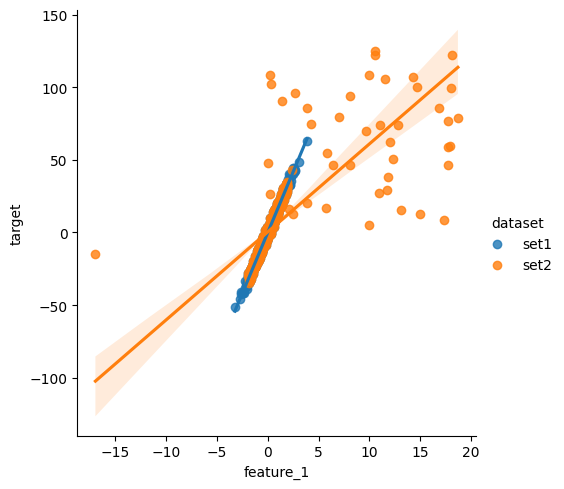

In [24]:
sns.lmplot(data = pd.concat([df.assign(dataset = 'set1'),
                                 df_outlier.assign(dataset = 'set2')]),
                x = 'feature_1',
                y = 'target',
                hue = 'dataset')

### Quinto ejercicio

Crear una función que separe los datos en train-validation-test 70-20-10


Hints: 

* Usar Indexing y slicing
* Usar np.random.[...]

In [56]:
def split(df: pd.DataFrame):
    samples = df.shape[0]
    indexes = np.random.permutation(np.arange(0, samples)) 

    #train 70
    train_idx = indexes[0:int( 0.7 * samples )]
    #validation 20
    val_idx = indexes[int( 0.7 * samples ): int( 0.9 * samples )]
    #test 10
    test_idx = indexes[int( 0.9 * samples ):] 

    #Segmentación
    #train
    X_train = df.iloc[train_idx,:-1] 
    Y_train = df.iloc[train_idx,-1:]
    #validation
    X_validation = df.iloc[val_idx,:-1]
    Y_validation = df.iloc[val_idx,-1:]
    #test
    X_test =  df.iloc[test_idx,:-1] 
    Y_test = df.iloc[test_idx,-1:]
    
    return X_train, X_validation, X_test, Y_train, Y_validation, Y_test

In [101]:
dataset = np.arange(100).reshape((10,10))
dataset = pd.DataFrame(dataset)
X_train, X_validation, X_test, Y_train, Y_validation, Y_test = split(dataset)

print("train-validation-test 70-20-10")
print("train")
train_x_y = np.concatenate((X_train,Y_train),1)
print(train_x_y)

print("validation")
validation_x_y = np.concatenate((X_validation,Y_validation),1)
print(validation_x_y)

print("test")
test_x_y = np.concatenate((X_test,Y_test),1)
print(test_x_y)


train-validation-test 70-20-10
train
[[ 0  1  2  3  4  5  6  7  8  9]
 [90 91 92 93 94 95 96 97 98 99]
 [60 61 62 63 64 65 66 67 68 69]
 [40 41 42 43 44 45 46 47 48 49]
 [80 81 82 83 84 85 86 87 88 89]
 [50 51 52 53 54 55 56 57 58 59]
 [70 71 72 73 74 75 76 77 78 79]]
validation
[[30 31 32 33 34 35 36 37 38 39]
 [20 21 22 23 24 25 26 27 28 29]]
test
[[10 11 12 13 14 15 16 17 18 19]]


### Sexto ejercicio

Utilizando la funcion `generate_outliers` generar puntos extremos dentro de los datos que generamos anteriormente. En este ejercicio dejar setteado `extreme_outliers` como `False` y observe como variando el porcentaje de los mismos la regresión comienza a afectarse.

Pasos:

1. Generar datasets:
    - Uno normal con poco `noise` y pocos outliers
    - Uno con mucho `noise` y pocos outliers
    - Uno con poco `noise` y muchos outliers
    - Uno con mucho `noise` y muchos outliers
2. Probar los distintos regresores a ver como se comportan frente a estos datasets anómalos.
3. Comparar y analizar resultados.

In [26]:
# Creamos un dataset de prueba
## Utilicen mas `n_features` > 1 y n_informative mas o menos la mitad de n_features
X, y = make_regression(n_samples = 1000,
                       n_features = 10,
                       noise = 100,
                       n_informative = 5,
                       random_state = 42)

new_data = np.append(X,y.reshape(-1,1),axis=1)

df = pd.DataFrame(new_data)

new_col = []
i = 0
for col in df.columns:
    if i ==  len(df.columns) - 1:
        new_col.append("target")
    else :
        new_col.append("feature_" + str(i+1))
        
    i += 1
    
df.columns = new_col

df.head()

,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,target
0,0.123429,-1.253402,0.370340,0.101788,0.092628,-0.589254,0.306348,-1.458213,1.630130,1.242863,-44.755165
1,-0.216827,0.214983,-0.028817,-1.701140,0.264482,0.314972,0.374062,-0.292758,0.501900,0.063702,-16.218565
2,0.388979,1.655407,-0.755792,-1.161784,-0.300860,1.048707,-0.283139,0.251474,-0.194269,-1.209477,-9.541669
3,0.219072,-0.251552,-1.095871,-0.806520,-0.435139,2.768374,1.677201,-0.475392,-0.835870,-1.314879,94.835887
4,0.715734,0.383168,-0.686715,-1.236136,0.731001,1.623885,1.254338,2.394362,2.185095,0.538435,-161.502563


In [27]:
from sklearn.linear_model import LinearRegression, HuberRegressor, ElasticNetCV

## Tercera Parte (Clase 5, 6 y 7)

La ultima parte la van a poder encontrar en el archivo `template_tp_integrador_tercera_parte.ipynb`